In [1]:
import os
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()


2025-08-13 11:07:25.547434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755058045.578839  395070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755058045.588300  395070 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-13 11:07:25.649855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1


0

In [2]:
# ----------------------------
# Phonetic Map (ID to string)
# ----------------------------
phonetic_map = {
    1: "a", 2: "i", 3: "u", 4: "e", 
    5: "o", 6: "é", 7: "eu",
    8: "ka", 9: "ga", 10: "nga", 11: "ca", 
    12: "ja", 13: "nya",
    14: "ta", 15: "da", 16: "na", 17: "pa", 
    18: "ba", 19: "ma",
    20: "ya", 21: "ra", 22: "la", 23: "wa", 
    24: "sa", 25: "ha",
    26: "fa", 27: "qa", 28: "va", 29: "xa", 
    30: "za", 31: "sya", 32: "kha",
    33: "-i", 34: "-u", 35: "-é", 36: "-e", 
    37: "-eu", 38: "-o",
    39: "-r", 40: "-h", 41: "-ng", 42: "-", 
    43: "-r-", 44: "-y-", 45: "-l-"
}

In [7]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0


# ----------------------------
# Data Generator
# ----------------------------
class CTCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, json_path, batch_size=32, image_size=(224, 224), shuffle=True, **kwargs):
        super().__init__(**kwargs)
        with open(json_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)

        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
        

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[k] for k in batch_indexes]

        images = np.zeros((len(batch_data), *self.image_size, 3), dtype=np.float32)
        labels = []
        input_lengths = []
        label_lengths = []

        for i, item in enumerate(batch_data):
            img = Image.open(item["url_file"]).convert("RGB")
            img = img.resize(self.image_size)
            img = np.asarray(img).astype(np.float32) / 255.0
            images[i] = img
            labels.append(item["label"])
            input_lengths.append(item["input_length"] if isinstance(item["input_length"], int) else item["input_length"][0])
            label_lengths.append(item["label_length"] if isinstance(item["label_length"], int) else item["label_length"][0])

        if len(label_lengths) == 0:
            print(f"Batch kosong pada index {index}. Melewati.")
            raise StopIteration  # atau cukup continue
        
        max_label_len = max(label_lengths)
        padded_labels = np.full((len(labels), max_label_len), -1, dtype=np.int32)
        
        for i, l in enumerate(labels):
            padded_labels[i, :len(l)] = l
       
        return (
            {
                "image_ctc": images,
                "labels": padded_labels,
                "input_length": np.array(input_lengths).reshape(-1, 1),
                "label_length": np.array(label_lengths).reshape(-1, 1),
            },
            # np.zeros((len(images)))
            np.zeros((len(images), 1), dtype=np.float32)
            # None
        )

# ----------------------------
# CTC Loss Layer
# ----------------------------
@tf.keras.utils.register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
# ----------------------------
# EfficientNetB0 + CNN-RNN + CTC Model
# ----------------------------
vocab_size = max(phonetic_map.keys()) + 1  # Pastikan gunakan nilai

def model_builder(hp):
    dropout_rate = hp.Float("dropout", min_value=0.2, max_value=0.4, step=0.1, default=0.2)
    learning_rate = hp.Choice("learning_rate", values=[1e-3, 5e-5, 1e-4], default=1e-4)
    
    input_img = layers.Input(shape=(224, 224, 3), name='image_ctc')
    base_model = EfficientNetB0(include_top=False, input_tensor=input_img, weights='imagenet')

    fine_tune_at = 163
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    x = base_model.output
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(vocab_size, activation='softmax', name='logits')(x)

    labels = layers.Input(name='labels', shape=(None,), dtype='int32')
    input_length = layers.Input(name='input_length', shape=(1,), dtype='int32')
    label_length = layers.Input(name='label_length', shape=(1,), dtype='int32')
    loss_out = layers.Lambda(ctc_lambda_func, name='ctc')([logits, labels, input_length, label_length])

    model = Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)
    
    return model

In [9]:
from sklearn.model_selection import StratifiedKFold
import keras_tuner as kt
import pandas as pd

def run_hyperparameter_tuning(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    labels = [os.path.basename(os.path.dirname(item["url_file"])) for item in data]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_idx, val_idx = list(skf.split(data, labels))[0]
    train_data = [data[i] for i in train_idx]
    val_data = [data[i] for i in val_idx]

    os.makedirs("ctc_dataset/tmp_split_tune", exist_ok=True)
    with open("ctc_dataset/tmp_split_tune/train.json", 'w', encoding='utf-8') as f_train:
        json.dump(train_data, f_train)
    with open("ctc_dataset/tmp_split_tune/val.json", 'w', encoding='utf-8') as f_val:
        json.dump(val_data, f_val)

    train_gen = CTCDataGenerator("ctc_dataset/tmp_split_tune/train.json", batch_size=32)
    val_gen = CTCDataGenerator("ctc_dataset/tmp_split_tune/val.json", batch_size=32)

    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
            {
                "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
            },
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        )
    )
    val_dataset = tf.data.Dataset.from_generator(
        lambda: val_gen,
        output_signature=(
            {
                "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
            },
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        )
    )

    NUM_TRIALS = 12

    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=NUM_TRIALS,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='ctc_tuning_revision'
    )
    tuner.search(train_dataset, validation_data=val_dataset, epochs=5)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    trials = tuner.oracle.get_best_trials(num_trials=NUM_TRIALS)
    all_results = []
    for trial in trials:
        all_results.append({
            'dropout': trial.hyperparameters.get('dropout'),
            'learning_rate': trial.hyperparameters.get('learning_rate'),
            'val_accuracy': trial.score
        })

    # Tampilkan hasil tuning
    print("\n📊 Hasil Tuning:")
    tuning_df = pd.DataFrame(all_results)
    print(tuning_df)
    best_hps = tuner.get_best_hyperparameters(1)[0]
    best_lr = best_hps.get('learning_rate')
    best_dropout = best_hps.get('dropout')

    print(f"✅ Best Hyperparameters: learning_rate={best_lr}, dropout={best_dropout}")
    return best_hp.get('dropout'), best_hp.get('learning_rate')

json_path = "ctc_dataset/combined_file_list_training.json"
print("🔍 Starting Hyperparameter Tuning...")
best_dropout, best_lr = run_hyperparameter_tuning(json_path)
print(f"✅ Best Hyperparameters: Dropout={best_dropout}, LearningRate={best_lr}")

Trial 9 Complete [00h 08m 19s]
val_loss: 3.528581142425537

Best val_loss So Far: 2.0947227478027344
Total elapsed time: 01h 16m 43s

📊 Hasil Tuning:
   dropout  learning_rate  val_accuracy
0      0.2        0.00010      2.094723
1      0.3        0.00010      2.211102
2      0.4        0.00010      2.422669
3      0.3        0.00005      3.466292
4      0.4        0.00005      3.528581
5      0.2        0.00005      3.661938
6      0.4        0.00100      4.616966
7      0.3        0.00100      4.682840
8      0.2        0.00100      4.820440
✅ Best Hyperparameters: learning_rate=0.0001, dropout=0.2
✅ Best Hyperparameters: Dropout=0.2, LearningRate=0.0001


In [10]:
import matplotlib.pyplot as plt
import json, os
import csv
import tensorflow as tf
from tensorflow.keras import callbacks, Model

class LearningRateLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

EPOCHS = 30

def run_stratified_kfold_with_tuning(json_path,  dropout, learning_rate, n_splits=5, batch_size=32, image_size=(224, 224)):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    def extract_folder_label(path):
        parts = path.replace("\\", "/").split("/")
        if "training" in parts:
            idx = parts.index("training")
            if idx + 1 < len(parts):
                return parts[idx + 1]
        return "unknown"

    labels = [extract_folder_label(item["url_file"]) for item in data]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"\n🔁 Fold {fold + 1}/{n_splits}")

        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]

        os.makedirs("ctc_dataset/tmp_split_revision", exist_ok=True)
        train_json = f"ctc_dataset/tmp_split_revision/train_fold_{fold}.json"
        val_json = f"ctc_dataset/tmp_split_revision/val_fold_{fold}.json"
        with open(train_json, 'w', encoding='utf-8') as f_train:
            json.dump(train_data, f_train, ensure_ascii=False)
        with open(val_json, 'w', encoding='utf-8') as f_val:
            json.dump(val_data, f_val, ensure_ascii=False)

        train_gen = CTCDataGenerator(train_json, batch_size=batch_size, image_size=image_size)
        val_gen = CTCDataGenerator(val_json, batch_size=batch_size, image_size=image_size)

        train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen,
            output_signature=(
                {
                    "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                    "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                    "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                    "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                },
                tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            )
        )
        val_dataset = tf.data.Dataset.from_generator(
            lambda: val_gen,
            output_signature=(
                {
                    "image_ctc": tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                    "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
                    "input_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                    "label_length": tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
                },
                tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            )
        )

        hp_fixed = kt.HyperParameters()
        hp_fixed.Fixed('dropout', dropout)
        hp_fixed.Fixed('learning_rate', learning_rate)
        model = model_builder(hp_fixed)

        save_dir = "ctc_dataset/saved_models/finetune_v2_revision/"
        os.makedirs(save_dir, exist_ok=True)

        checkpoint = callbacks.ModelCheckpoint(
            f"{save_dir}/best_model_fold_{fold}.h5", monitor='val_loss', save_best_only=True, verbose=1)
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        # lr_reduce = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
        lr_logger = LearningRateLogger()

        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=len(train_gen),
            validation_steps=len(val_gen),
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop, lr_logger]
        )

        # === Save inference model ===
        input_img = model.inputs[0]
        logits_out = model.get_layer("logits").output
        inference_model = tf.keras.Model(inputs=input_img, outputs=logits_out)
        inference_model.save(f"{save_dir}/infer_model_fold_{fold}.h5")

        # === Plot loss ===
        plt.figure(figsize=(5, 5))
        epochs_range = range(1, len(history.history['loss']) + 1)
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        val_min_epoch = np.argmin(val_loss) + 1
        val_min_value = np.min(val_loss)

        plt.plot(epochs_range, train_loss, label='Training Loss', color='blue', marker='.')
        plt.plot(epochs_range, val_loss, label=f'Validation Loss (min: {val_min_value:.4f} at epoch {val_min_epoch})', color='orange', marker='.')
        plt.scatter(val_min_epoch, val_min_value, color='orange', s=40, zorder=5)
        plt.text(val_min_epoch, val_min_value + 0.01, f'{val_min_value:.4f}', color='orange', fontsize=9)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold + 1} - Training vs Validation Loss')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.tight_layout()

        plot_path = f"{save_dir}/loss_plot_fold_{fold}.png"
        plt.savefig(plot_path)
        plt.close()

        # === Save history ===
        csv_path = f"{save_dir}/history_fold_{fold}.csv"
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])
            for i, (tl, vl) in enumerate(zip(train_loss, val_loss)):
                writer.writerow([i + 1, tl, vl])

# Jalankan
# run_stratified_kfold_with_tuning("ctc_dataset/combined_file_list_training.json", n_splits=5, batch_size=32)

json_path = "ctc_dataset/combined_file_list_training.json"
print("🔍 Starting Hyperparameter Tuning...")
best_dropout, best_lr = run_hyperparameter_tuning(json_path)
print(f"✅ Best Hyperparameters: Dropout={best_dropout}, LearningRate={best_lr}")
print("\n🚀 Starting Full 5-Fold Training...")
run_stratified_kfold_with_tuning(json_path, best_dropout, best_lr, n_splits=5)

🔍 Starting Hyperparameter Tuning...
Reloading Tuner from tuner_dir/ctc_tuning_revision/tuner0.json

📊 Hasil Tuning:
   dropout  learning_rate  val_accuracy
0      0.2        0.00010      2.094723
1      0.3        0.00010      2.211102
2      0.4        0.00010      2.422669
3      0.3        0.00005      3.466292
4      0.4        0.00005      3.528581
5      0.2        0.00005      3.661938
6      0.4        0.00100      4.616966
7      0.3        0.00100      4.682840
8      0.2        0.00100      4.820440
✅ Best Hyperparameters: learning_rate=0.0001, dropout=0.2
✅ Best Hyperparameters: Dropout=0.2, LearningRate=0.0001

🚀 Starting Full 5-Fold Training...

🔁 Fold 1/5
Epoch 1/30


E0000 00:00:1755063441.543437  395070 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


487/499 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 7.5552Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 5.90681, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 112s 195ms/step - loss: 7.5223 - val_loss: 5.9068 - lr: 1.0000e-04
Epoch 2/30


2025-08-13 12:39:00.199812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:39:00.199868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:39:00.199881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:39:00.199890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962
/home/gaaf/thesis-ocr-aksara-sunda/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 5.90681
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 5.9068 - lr: 1.0000e-04
Epoch 3/30
480/499 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 5.0642Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 5.90681 to 4.25851, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 5.0510 - val_loss: 4.2585 - lr: 1.0000e-04
Epoch 4/30


2025-08-13 12:40:46.794976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:40:46.795034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:40:46.795050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:40:46.795059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.25851
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 4.2585 - lr: 1.0000e-04
Epoch 5/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 3.7924 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.25851 to 3.76356, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 3.7804 - val_loss: 3.7636 - lr: 1.0000e-04
Epoch 6/30


2025-08-13 12:42:33.083034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:42:33.083090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:42:33.083104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:42:33.083112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.76356
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 3.7636 - lr: 1.0000e-04
Epoch 7/30
484/499 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 3.0240Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.76356 to 2.96626, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 97s 193ms/step - loss: 3.0202 - val_loss: 2.9663 - lr: 1.0000e-04
Epoch 8/30


2025-08-13 12:44:22.140172: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:44:22.140249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:44:22.140264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:44:22.140272: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.96626
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 2.9663 - lr: 1.0000e-04
Epoch 9/30
475/499 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 2.5679Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.96626 to 2.30395, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 2.5633 - val_loss: 2.3039 - lr: 1.0000e-04
Epoch 10/30


2025-08-13 12:46:08.127272: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:46:08.127321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:46:08.127334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:46:08.127341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.30395
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.3039 - lr: 1.0000e-04
Epoch 11/30
491/499 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 2.2106Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.30395 to 1.96498, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 191ms/step - loss: 2.2095 - val_loss: 1.9650 - lr: 1.0000e-04
Epoch 12/30


2025-08-13 12:47:55.902191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:47:55.902252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:47:55.902268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:47:55.902277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.96498
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.9650 - lr: 1.0000e-04
Epoch 13/30
480/499 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.9635Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.96498 to 1.67687, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.9609 - val_loss: 1.6769 - lr: 1.0000e-04
Epoch 14/30


2025-08-13 12:49:42.834301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:49:42.834358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:49:42.834373: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:49:42.834382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.67687
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.6769 - lr: 1.0000e-04
Epoch 15/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 1.7140Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.67687 to 1.51531, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.7113 - val_loss: 1.5153 - lr: 1.0000e-04
Epoch 16/30


2025-08-13 12:51:28.906034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:51:28.906091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:51:28.906104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:51:28.906112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.51531
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.5153 - lr: 1.0000e-04
Epoch 17/30
472/499 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 1.4912 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.51531 to 1.32367, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.4894 - val_loss: 1.3237 - lr: 1.0000e-04
Epoch 18/30


2025-08-13 12:53:14.388024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:53:14.388082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:53:14.388096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:53:14.388104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.32367
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.3237 - lr: 1.0000e-04
Epoch 19/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.2761Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.32367 to 1.24450, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - loss: 1.2759 - val_loss: 1.2445 - lr: 1.0000e-04
Epoch 20/30


2025-08-13 12:55:00.037952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:55:00.038002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:55:00.038015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:55:00.038022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.24450
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.2445 - lr: 1.0000e-04
Epoch 21/30
473/499 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 1.1348Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.24450 to 1.22564, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 155ms/step - loss: 1.1334 - val_loss: 1.2256 - lr: 1.0000e-04
Epoch 22/30


2025-08-13 12:56:43.673684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:56:43.673739: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:56:43.673754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:56:43.673762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.22564
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 1.2256 - lr: 1.0000e-04
Epoch 23/30
482/499 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.9938Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.22564 to 1.02381, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 106s 213ms/step - loss: 0.9923 - val_loss: 1.0238 - lr: 1.0000e-04
Epoch 24/30


2025-08-13 12:58:41.702707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 12:58:41.702759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 12:58:41.702773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 12:58:41.702782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.02381
499/499 ━━━━━━━━━━━━━━━━━━━━ -3s -5194us/step - loss: 0.0000e+00 - val_loss: 1.0238 - lr: 1.0000e-04
Epoch 25/30
495/499 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.8623Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 1.02381 to 0.98727, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - loss: 0.8620 - val_loss: 0.9873 - lr: 1.0000e-04
Epoch 26/30


2025-08-13 13:00:10.710878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 13:00:10.710927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 13:00:10.710939: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 13:00:10.710945: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.98727
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 0.9873 - lr: 1.0000e-04
Epoch 27/30
493/499 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.7397Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.98727 to 0.84964, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_0.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 0.7395 - val_loss: 0.8496 - lr: 1.0000e-04
Epoch 28/30


2025-08-13 13:01:56.735246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 13:01:56.735316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 13:01:56.735336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 13:01:56.735348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.84964
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 0.8496 - lr: 1.0000e-04
Epoch 29/30
484/499 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.6321Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss did not improve from 0.84964
499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - loss: 0.6323 - val_loss: 0.8529 - lr: 1.0000e-04
Epoch 30/30


2025-08-13 13:03:42.246693: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14236248370516370946
2025-08-13 13:03:42.246750: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2259107030091289764
2025-08-13 13:03:42.246764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7508564888765386442
2025-08-13 13:03:42.246773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17168615438347136962


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.84964
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 0.8529 - lr: 1.0000e-04



🔁 Fold 2/5
Epoch 1/30


E0000 00:00:1755065066.226583  395070 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


485/499 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 7.6024Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 5.55118, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 116s 197ms/step - loss: 7.5653 - val_loss: 5.5512 - lr: 1.0000e-04
Epoch 2/30


2025-08-13 13:05:51.636306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:05:51.636361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:05:51.636375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:05:51.636383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 5.55118
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 5.5512 - lr: 1.0000e-04
Epoch 3/30
482/499 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 4.9737Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 5.55118 to 4.91527, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 4.9586 - val_loss: 4.9153 - lr: 1.0000e-04
Epoch 4/30


2025-08-13 13:07:38.898211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:07:38.898267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:07:38.898280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:07:38.898288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.91527
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 4.9153 - lr: 1.0000e-04
Epoch 5/30
496/499 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 3.6829Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.91527 to 3.50362, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 3.6807 - val_loss: 3.5036 - lr: 1.0000e-04
Epoch 6/30


2025-08-13 13:09:26.661967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:09:26.662018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:09:26.662030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:09:26.662037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.50362
499/499 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - loss: 0.0000e+00 - val_loss: 3.5036 - lr: 1.0000e-04
Epoch 7/30
483/499 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 2.9881Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.50362 to 2.59027, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 81s 191ms/step - loss: 2.9817 - val_loss: 2.5903 - lr: 1.0000e-04
Epoch 8/30


2025-08-13 13:11:14.163772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:11:14.163825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:11:14.163839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:11:14.163846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.59027
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.5903 - lr: 1.0000e-04
Epoch 9/30
478/499 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 2.5664 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.59027 to 2.25117, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 2.5605 - val_loss: 2.2512 - lr: 1.0000e-04
Epoch 10/30


2025-08-13 13:13:00.181097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:13:00.181148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:13:00.181161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:13:00.181168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.25117
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 2.2512 - lr: 1.0000e-04
Epoch 11/30
471/499 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 2.2566 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.25117 to 1.99923, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 2.2491 - val_loss: 1.9992 - lr: 1.0000e-04
Epoch 12/30


2025-08-13 13:14:46.122656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:14:46.122712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:14:46.122726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:14:46.122734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.99923
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.9992 - lr: 1.0000e-04
Epoch 13/30
494/499 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.9698Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.99923 to 1.64340, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.9686 - val_loss: 1.6434 - lr: 1.0000e-04
Epoch 14/30


2025-08-13 13:16:32.699573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:16:32.699631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:16:32.699652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:16:32.699666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.64340
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.6434 - lr: 1.0000e-04
Epoch 15/30
485/499 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 1.7365Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 15: val_loss did not improve from 1.64340
499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 1.7340 - val_loss: 1.6470 - lr: 1.0000e-04
Epoch 16/30


2025-08-13 13:18:18.651942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:18:18.651997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:18:18.652023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:18:18.652031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.64340
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.6470 - lr: 1.0000e-04
Epoch 17/30
478/499 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 1.5389Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.64340 to 1.49304, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 1.5351 - val_loss: 1.4930 - lr: 1.0000e-04
Epoch 18/30


2025-08-13 13:20:06.579776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:20:06.579831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:20:06.579882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:20:06.579921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.49304
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 1.4930 - lr: 1.0000e-04
Epoch 19/30
490/499 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 1.3527Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.49304 to 1.24903, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.3512 - val_loss: 1.2490 - lr: 1.0000e-04
Epoch 20/30


2025-08-13 13:21:54.193987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:21:54.194038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:21:54.194051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:21:54.194058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.24903
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.2490 - lr: 1.0000e-04
Epoch 21/30
481/499 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.2000Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.24903 to 1.11510, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.1976 - val_loss: 1.1151 - lr: 1.0000e-04
Epoch 22/30


2025-08-13 13:23:41.034673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:23:41.034746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:23:41.034761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:23:41.034770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.11510
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.1151 - lr: 1.0000e-04
Epoch 23/30
469/499 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 1.0610 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.11510 to 1.01780, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 1.0566 - val_loss: 1.0178 - lr: 1.0000e-04
Epoch 24/30


2025-08-13 13:25:27.784956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:25:27.785001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:25:27.785011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:25:27.785018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.01780
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.0178 - lr: 1.0000e-04
Epoch 25/30
482/499 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.8917Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 1.01780 to 0.93826, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 164ms/step - loss: 0.8900 - val_loss: 0.9383 - lr: 1.0000e-04
Epoch 26/30


2025-08-13 13:27:15.987460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:27:15.987515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:27:15.987529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:27:15.987536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.93826
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9383 - lr: 1.0000e-04
Epoch 27/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.7763Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.93826 to 0.85977, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 0.7760 - val_loss: 0.8598 - lr: 1.0000e-04
Epoch 28/30


2025-08-13 13:29:03.714738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:29:03.714784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:29:03.714811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:29:03.714819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.85977
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 0.8598 - lr: 1.0000e-04
Epoch 29/30
483/499 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.6686Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.85977 to 0.78477, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 0.6677 - val_loss: 0.7848 - lr: 1.0000e-04
Epoch 30/30


2025-08-13 13:30:51.418866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5579000307896835914
2025-08-13 13:30:51.418943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8540090512717010160
2025-08-13 13:30:51.418980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17651074326636543360
2025-08-13 13:30:51.419036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4624211106354036682
2025-08-13 13:30:51.419088: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_8]]


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.78477
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 0.7848 - lr: 1.0000e-04



🔁 Fold 3/5
Epoch 1/30


E0000 00:00:1755066679.273456  395070 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


480/499 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 7.6737Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 8.50149, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 113s 196ms/step - loss: 7.6285 - val_loss: 8.5015 - lr: 1.0000e-04
Epoch 2/30


2025-08-13 13:32:58.689041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:32:58.689100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:32:58.689116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:32:58.689126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 8.50149
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 8.5015 - lr: 1.0000e-04
Epoch 3/30
491/499 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 5.0350Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 8.50149 to 3.79990, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 5.0288 - val_loss: 3.7999 - lr: 1.0000e-04
Epoch 4/30


2025-08-13 13:34:44.796654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:34:44.796706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:34:44.796719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:34:44.796767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 3.79990
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 3.7999 - lr: 1.0000e-04
Epoch 5/30
476/499 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 3.7348Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 3.79990 to 3.35337, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 3.7244 - val_loss: 3.3534 - lr: 1.0000e-04
Epoch 6/30


2025-08-13 13:36:32.432898: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:36:32.432941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:36:32.432953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:36:32.432961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.35337
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 3.3534 - lr: 1.0000e-04
Epoch 7/30
493/499 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 2.9541Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.35337 to 3.21106, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 2.9529 - val_loss: 3.2111 - lr: 1.0000e-04
Epoch 8/30


2025-08-13 13:38:20.092466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:38:20.092514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:38:20.092525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:38:20.092532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 3.21106
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 3.2111 - lr: 1.0000e-04
Epoch 9/30
471/499 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - loss: 2.5372 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 3.21106 to 2.50260, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 97s 194ms/step - loss: 2.5332 - val_loss: 2.5026 - lr: 1.0000e-04
Epoch 10/30


2025-08-13 13:40:08.611254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:40:08.611308: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:40:08.611322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:40:08.611330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.50260
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.5026 - lr: 1.0000e-04
Epoch 11/30
490/499 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 2.1901Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.50260 to 2.08516, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 2.1894 - val_loss: 2.0852 - lr: 1.0000e-04
Epoch 12/30


2025-08-13 13:41:55.703700: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:41:55.703763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:41:55.703779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:41:55.703787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 2.08516
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.0852 - lr: 1.0000e-04
Epoch 13/30
475/499 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 1.9108Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 2.08516 to 1.89527, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 1.9096 - val_loss: 1.8953 - lr: 1.0000e-04
Epoch 14/30


2025-08-13 13:43:43.412279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:43:43.412337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:43:43.412351: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:43:43.412360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.89527
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.8953 - lr: 1.0000e-04
Epoch 15/30
495/499 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 1.6991Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.89527 to 1.40259, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.6989 - val_loss: 1.4026 - lr: 1.0000e-04
Epoch 16/30


2025-08-13 13:45:29.946512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:45:29.946566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:45:29.946580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:45:29.946588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.40259
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.4026 - lr: 1.0000e-04
Epoch 17/30
490/499 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 1.4535Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 17: val_loss did not improve from 1.40259
499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - loss: 1.4533 - val_loss: 1.4140 - lr: 1.0000e-04
Epoch 18/30


2025-08-13 13:47:16.003678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:47:16.003742: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:47:16.003757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:47:16.003773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.40259
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.4140 - lr: 1.0000e-04
Epoch 19/30
476/499 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 1.2633 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.40259 to 1.14271, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 1.2630 - val_loss: 1.1427 - lr: 1.0000e-04
Epoch 20/30


2025-08-13 13:49:03.997014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:49:03.997069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:49:03.997084: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:49:03.997093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.14271
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.1427 - lr: 1.0000e-04
Epoch 21/30
488/499 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 1.1345Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 21: val_loss did not improve from 1.14271
499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 1.1340 - val_loss: 1.1782 - lr: 1.0000e-04
Epoch 22/30


2025-08-13 13:50:51.598180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:50:51.598226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:50:51.598238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:50:51.598245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.14271
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.1782 - lr: 1.0000e-04
Epoch 23/30
477/499 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.9833 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.14271 to 1.03605, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 0.9827 - val_loss: 1.0360 - lr: 1.0000e-04
Epoch 24/30


2025-08-13 13:52:38.498743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:52:38.498798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:52:38.498812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:52:38.498820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.03605
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.0360 - lr: 1.0000e-04
Epoch 25/30
471/499 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.8448Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 1.03605 to 0.84507, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 0.8436 - val_loss: 0.8451 - lr: 1.0000e-04
Epoch 26/30


2025-08-13 13:54:25.246590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:54:25.246644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:54:25.246657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:54:25.246665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.84507
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0000e+00 - val_loss: 0.8451 - lr: 1.0000e-04
Epoch 27/30
479/499 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.7306Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.84507 to 0.79677, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_2.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 0.7303 - val_loss: 0.7968 - lr: 1.0000e-04
Epoch 28/30


2025-08-13 13:56:13.734267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:56:13.734321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:56:13.734335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:56:13.734343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.79677
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 0.7968 - lr: 1.0000e-04
Epoch 29/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.6566Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss did not improve from 0.79677
499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - loss: 0.6551 - val_loss: 0.8300 - lr: 1.0000e-04
Epoch 30/30


2025-08-13 13:57:59.024265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2155545510084193034
2025-08-13 13:57:59.024319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10744695739046890382
2025-08-13 13:57:59.024333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12836526825539466784
2025-08-13 13:57:59.024342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4093800788840894883


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.79677
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.8300 - lr: 1.0000e-04



🔁 Fold 4/5
Epoch 1/30


E0000 00:00:1755068320.309530  395070 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 7.6361Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 7.6335Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 6.33373, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 126s 194ms/step - loss: 7.6310 - val_loss: 6.3337 - lr: 1.0000e-04
Epoch 2/30


2025-08-13 14:00:18.532765: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:00:18.532823: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:00:18.532838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:00:18.532847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 6.33373
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 6.3337 - lr: 1.0000e-04
Epoch 3/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 5.0936Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 6.33373 to 4.35266, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 5.0915 - val_loss: 4.3527 - lr: 1.0000e-04
Epoch 4/30


2025-08-13 14:02:06.595064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:02:06.595115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:02:06.595128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:02:06.595134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 4.35266
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 4.3527 - lr: 1.0000e-04
Epoch 5/30
486/499 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 3.8106Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 4.35266 to 3.31195, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 3.8040 - val_loss: 3.3119 - lr: 1.0000e-04
Epoch 6/30


2025-08-13 14:03:53.343683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:03:53.343737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:03:53.343751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:03:53.343761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 3.31195
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 3.3119 - lr: 1.0000e-04
Epoch 7/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 3.0526 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 3.31195 to 2.82796, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 3.0455 - val_loss: 2.8280 - lr: 1.0000e-04
Epoch 8/30


2025-08-13 14:05:40.214906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:05:40.214963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:05:40.214978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:05:40.214986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.82796
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.8280 - lr: 1.0000e-04
Epoch 9/30
494/499 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 2.5760Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.82796 to 2.27125, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 2.5750 - val_loss: 2.2713 - lr: 1.0000e-04
Epoch 10/30


2025-08-13 14:07:26.996721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:07:26.996771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:07:26.996785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:07:26.996792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.27125
499/499 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.0000e+00 - val_loss: 2.2713 - lr: 1.0000e-04
Epoch 11/30
485/499 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 2.2919Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.27125 to 2.18613, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 81s 191ms/step - loss: 2.2892 - val_loss: 2.1861 - lr: 1.0000e-04
Epoch 12/30


2025-08-13 14:09:14.278825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:09:14.278881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:09:14.278926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:09:14.278965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 2.18613
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.1861 - lr: 1.0000e-04
Epoch 13/30
470/499 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 2.0337 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 2.18613 to 1.94442, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 2.0290 - val_loss: 1.9444 - lr: 1.0000e-04
Epoch 14/30


2025-08-13 14:11:01.427509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:11:01.427584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:11:01.427624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:11:01.427663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.94442
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.9444 - lr: 1.0000e-04
Epoch 15/30
482/499 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 1.7679Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.94442 to 1.62395, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 221ms/step - loss: 1.7658 - val_loss: 1.6239 - lr: 1.0000e-04
Epoch 16/30


2025-08-13 14:13:03.679879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:13:03.679930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:13:03.679942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:13:03.679948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.62395
499/499 ━━━━━━━━━━━━━━━━━━━━ -2s -4092us/step - loss: 0.0000e+00 - val_loss: 1.6239 - lr: 1.0000e-04
Epoch 17/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.5607Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.5606Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.62395 to 1.48830, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - loss: 1.5605 - val_loss: 1.4883 - lr: 1.0000e-04
Epoch 18/30


2025-08-13 14:14:51.586782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:14:51.586830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:14:51.586842: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:14:51.586848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.48830
499/499 ━━━━━━━━━━━━━━━━━━━━ -2s -4724us/step - loss: 0.0000e+00 - val_loss: 1.4883 - lr: 1.0000e-04
Epoch 19/30
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.3801Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.48830 to 1.35035, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - loss: 1.3798 - val_loss: 1.3504 - lr: 1.0000e-04
Epoch 20/30


2025-08-13 14:16:22.514950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:16:22.515025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:16:22.515065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:16:22.515108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.35035
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.3504 - lr: 1.0000e-04
Epoch 21/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 1.1768Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.35035 to 1.17361, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 97s 166ms/step - loss: 1.1744 - val_loss: 1.1736 - lr: 1.0000e-04
Epoch 22/30


2025-08-13 14:18:11.535791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:18:11.535857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:18:11.535872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:18:11.535881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.17361
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 1.1736 - lr: 1.0000e-04
Epoch 23/30
490/499 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 1.0416Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.17361 to 1.08061, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 1.0408 - val_loss: 1.0806 - lr: 1.0000e-04
Epoch 24/30


2025-08-13 14:19:59.032280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:19:59.032327: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:19:59.032340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:19:59.032346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 1.08061
499/499 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.0000e+00 - val_loss: 1.0806 - lr: 1.0000e-04
Epoch 25/30
479/499 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.8898Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 1.08061 to 0.99684, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - loss: 0.8885 - val_loss: 0.9968 - lr: 1.0000e-04
Epoch 26/30


2025-08-13 14:22:42.801661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:22:42.801721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:22:42.801744: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:22:42.801751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.99684
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9968 - lr: 1.0000e-04
Epoch 27/30
493/499 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.7649Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 27: val_loss improved from 0.99684 to 0.91313, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - loss: 0.7646 - val_loss: 0.9131 - lr: 1.0000e-04
Epoch 28/30


2025-08-13 14:24:28.795013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:24:28.795069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:24:28.795081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:24:28.795125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.91313
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9131 - lr: 1.0000e-04
Epoch 29/30
476/499 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - loss: 0.6823Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.91313 to 0.87162, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_3.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 193ms/step - loss: 0.6810 - val_loss: 0.8716 - lr: 1.0000e-04
Epoch 30/30


2025-08-13 14:26:17.043877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12942396887054404056
2025-08-13 14:26:17.043924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1640621555218974250
2025-08-13 14:26:17.043936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10727235445751177219
2025-08-13 14:26:17.043942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2563001356526636151


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.87162
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0000e+00 - val_loss: 0.8716 - lr: 1.0000e-04



🔁 Fold 5/5
Epoch 1/30


E0000 00:00:1755070006.477191  395070 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


493/499 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 7.5796Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 1: val_loss improved from inf to 6.49079, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 116s 199ms/step - loss: 7.5617 - val_loss: 6.4908 - lr: 1.0000e-04
Epoch 2/30


2025-08-13 14:28:26.910098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:28:26.910155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:28:26.910168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:28:26.910178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:28:26.910185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:28:26.910191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 2: val_loss did not improve from 6.49079
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 6.4908 - lr: 1.0000e-04
Epoch 3/30
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 4.7993Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 4.7975Batch kosong pada index 125. Melewati.

Epoch 3: val_loss improved from 6.49079 to 5.00253, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 4.7967 - val_loss: 5.0025 - lr: 1.0000e-04
Epoch 4/30


2025-08-13 14:30:13.011868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:30:13.011921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:30:13.011934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:30:13.011942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:30:13.011948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:30:13.011953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 4: val_loss did not improve from 5.00253
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 5.0025 - lr: 1.0000e-04
Epoch 5/30
491/499 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.5159Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 5: val_loss improved from 5.00253 to 2.99650, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 3.5113 - val_loss: 2.9965 - lr: 1.0000e-04
Epoch 6/30


2025-08-13 14:31:59.836612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:31:59.836679: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:31:59.836717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:31:59.836736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:31:59.836744: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 6: val_loss did not improve from 2.99650
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.9965 - lr: 1.0000e-04
Epoch 7/30
487/499 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 2.8596Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 7: val_loss improved from 2.99650 to 2.23746, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 2.8554 - val_loss: 2.2375 - lr: 1.0000e-04
Epoch 8/30


2025-08-13 14:33:45.649507: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:33:45.649568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:33:45.649582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:33:45.649592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:33:45.649598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:33:45.649604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 8: val_loss did not improve from 2.23746
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.2375 - lr: 1.0000e-04
Epoch 9/30
476/499 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 2.4316Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 9: val_loss improved from 2.23746 to 2.21726, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - loss: 2.4265 - val_loss: 2.2173 - lr: 1.0000e-04
Epoch 10/30


2025-08-13 14:35:33.205168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:35:33.205248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:35:33.205285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:35:33.205319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 10: val_loss did not improve from 2.21726
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 2.2173 - lr: 1.0000e-04
Epoch 11/30
494/499 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 2.1474Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 11: val_loss improved from 2.21726 to 1.83052, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 2.1462 - val_loss: 1.8305 - lr: 1.0000e-04
Epoch 12/30


2025-08-13 14:37:20.415581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:37:20.415638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:37:20.415652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:37:20.415661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 12: val_loss did not improve from 1.83052
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.8305 - lr: 1.0000e-04
Epoch 13/30
485/499 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 1.8678Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 13: val_loss improved from 1.83052 to 1.62978, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 109s 218ms/step - loss: 1.8652 - val_loss: 1.6298 - lr: 1.0000e-04
Epoch 14/30


2025-08-13 14:39:21.168784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:39:21.168833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:39:21.168846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:39:21.168855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:39:21.168860: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:39:21.168866: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 14: val_loss did not improve from 1.62978
499/499 ━━━━━━━━━━━━━━━━━━━━ -2s -4663us/step - loss: 0.0000e+00 - val_loss: 1.6298 - lr: 1.0000e-04
Epoch 15/30
474/499 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 1.6480 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 15: val_loss improved from 1.62978 to 1.39765, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.6441 - val_loss: 1.3976 - lr: 1.0000e-04
Epoch 16/30


2025-08-13 14:40:53.522128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:40:53.522184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:40:53.522198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:40:53.522242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:40:53.522257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:40:53.522264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 16: val_loss did not improve from 1.39765
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 1.3976 - lr: 1.0000e-04
Epoch 17/30
467/499 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 1.4119Batch kosong pada index 499. Melewati.
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.4077Batch kosong pada index 125. Melewati.

Epoch 17: val_loss improved from 1.39765 to 1.38306, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 1.4076 - val_loss: 1.3831 - lr: 1.0000e-04
Epoch 18/30


2025-08-13 14:42:40.066827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:42:40.066907: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:42:40.066928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:42:40.066963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 18: val_loss did not improve from 1.38306
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 1.3831 - lr: 1.0000e-04
Epoch 19/30
489/499 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 1.2388Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 19: val_loss improved from 1.38306 to 1.07967, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - loss: 1.2376 - val_loss: 1.0797 - lr: 1.0000e-04
Epoch 20/30


2025-08-13 14:44:26.781851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:44:26.781931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:44:26.781954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:44:26.781989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 20: val_loss did not improve from 1.07967
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 1.0797 - lr: 1.0000e-04
Epoch 21/30
483/499 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.0794Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 21: val_loss improved from 1.07967 to 1.04567, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - loss: 1.0774 - val_loss: 1.0457 - lr: 1.0000e-04
Epoch 22/30


2025-08-13 14:46:26.741899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:46:26.741952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8368803905618170355
2025-08-13 14:46:26.741967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:46:26.741975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:46:26.741983: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:46:26.741990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:46:26.741996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

Batch kosong pada index 125. Melewati.

Epoch 22: val_loss did not improve from 1.04567
499/499 ━━━━━━━━━━━━━━━━━━━━ -3s -5167us/step - loss: 0.0000e+00 - val_loss: 1.0457 - lr: 1.0000e-04
Epoch 23/30
480/499 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.9428Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 23: val_loss improved from 1.04567 to 0.97777, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - loss: 0.9405 - val_loss: 0.9778 - lr: 1.0000e-04
Epoch 24/30


2025-08-13 14:47:57.982211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:47:57.982262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:47:57.982276: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:47:57.982285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:47:57.982292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:47:57.982298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 24: val_loss did not improve from 0.97777
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0000e+00 - val_loss: 0.9778 - lr: 1.0000e-04
Epoch 25/30
475/499 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.8252 Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 25: val_loss improved from 0.97777 to 0.87464, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - loss: 0.8222 - val_loss: 0.8746 - lr: 1.0000e-04
Epoch 26/30


2025-08-13 14:49:44.483488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:49:44.483566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:49:44.483589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:49:44.483625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 26: val_loss did not improve from 0.87464
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.8746 - lr: 1.0000e-04
Epoch 27/30
493/499 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.7245Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 27: val_loss did not improve from 0.87464
499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 189ms/step - loss: 0.7239 - val_loss: 0.9888 - lr: 1.0000e-04
Epoch 28/30


2025-08-13 14:51:30.904124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230
2025-08-13 14:51:30.904200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:51:30.904224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:51:30.904260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015


Batch kosong pada index 125. Melewati.

Epoch 28: val_loss did not improve from 0.87464
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0000e+00 - val_loss: 0.9888 - lr: 1.0000e-04
Epoch 29/30
485/499 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.6094Batch kosong pada index 499. Melewati.
Batch kosong pada index 125. Melewati.

Epoch 29: val_loss improved from 0.87464 to 0.78332, saving model to ctc_dataset/saved_models/finetune_v2_revision//best_model_fold_4.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - loss: 0.6089 - val_loss: 0.7833 - lr: 1.0000e-04
Epoch 30/30


2025-08-13 14:53:32.530710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1529342352375441649
2025-08-13 14:53:32.530761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8883834230161892433
2025-08-13 14:53:32.530774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16302193301247332015
2025-08-13 14:53:32.530781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18144102365007716506
2025-08-13 14:53:32.530787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17469662929652230436
2025-08-13 14:53:32.530792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15555782320706492230


Batch kosong pada index 125. Melewati.

Epoch 30: val_loss did not improve from 0.78332
499/499 ━━━━━━━━━━━━━━━━━━━━ -2s -4584us/step - loss: 0.0000e+00 - val_loss: 0.7833 - lr: 1.0000e-04



🔍 Fold 0 - Kata yang paling sering salah:
ga: 17 kali salah
ta -i: 17 kali salah
a: 16 kali salah
i: 14 kali salah
eu: 11 kali salah
nga: 10 kali salah
xa: 9 kali salah
é: 8 kali salah
ba la -é: 6 kali salah
ha ya -u: 6 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : ya
  ❌ Pred: ja

  ✅ GT : ya
  ❌ Pred: ra

✅ Fold 0 - CER: 0.0693, WER: 0.0869



🔍 Fold 1 - Kata yang paling sering salah:
a: 20 kali salah
é: 17 kali salah
za: 16 kali salah
ta -i: 16 kali salah
i: 12 kali salah
ga: 12 kali salah
ma: 11 kali salah
xa: 10 kali salah
eu: 10 kali salah
wa: 8 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: e

✅ Fold 1 - CER: 0.0748, WER: 0.0931



🔍 Fold 2 - Kata yang paling sering salah:
é: 14 kali salah
i: 14 kali salah
da -i: 14 kali salah
a: 13 kali salah
fa: 13 kali salah
za: 10 kali salah
eu: 10 kali salah
xa: 8 kali salah
nga: 8 kali salah
ta -i: 8 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: e

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

✅ Fold 2 - CER: 0.0734, WER: 0.0930



🔍 Fold 3 - Kata yang paling sering salah:
é: 28 kali salah
xa: 23 kali salah
da -i: 18 kali salah
u: 13 kali salah
fa: 12 kali salah
a: 11 kali salah
ma: 10 kali salah
ya: 9 kali salah
sa: 8 kali salah
nga: 8 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

✅ Fold 3 - CER: 0.0813, WER: 0.1005



🔍 Fold 4 - Kata yang paling sering salah:
da -i: 26 kali salah
é: 20 kali salah
a: 19 kali salah
ta -i: 17 kali salah
e: 11 kali salah
ga: 9 kali salah
u: 8 kali salah
ka: 8 kali salah
nga: 8 kali salah
wa: 7 kali salah

📌 Contoh kesalahan prediksi:
  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: eu

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

  ✅ GT : é
  ❌ Pred: a

✅ Fold 4 - CER: 0.0746, WER: 0.0874
📊 Grafik evaluasi disimpan sebagai 'evaluation_plot.png'


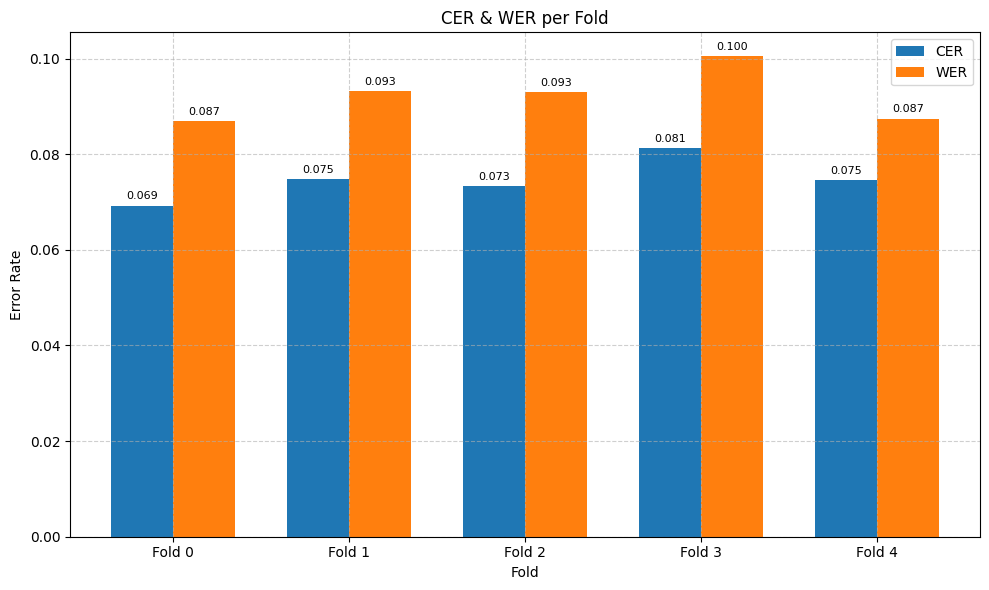

In [11]:
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import matplotlib.pyplot as plt
import editdistance
import os
from collections import Counter

# === Load mapping label numerik ke fonem ===
with open('ngalagena_swara_labels.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
int_to_label = {int(v): k for k, v in label_map.items()}

# === CTC decoding ===
def decode_prediction(pred, input_length):
    decoded, _ = ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)
    return decoded[0].numpy()

# === Evaluation Metrics ===
def cer(s1, s2):
    return editdistance.eval(s1, s2) / len(s2) if len(s2) > 0 else 1.0

def wer(ref, hyp):
    ref_words = ref.strip().split()
    hyp_words = hyp.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 1.0

# === Evaluasi model per fold ===
def evaluate_model(model_path, json_path):
    model = load_model(model_path, compile=False)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    cer_list = []
    wer_list = []
    true_texts = []
    pred_texts = []

    for item in tqdm(data, desc=f"Evaluating {os.path.basename(model_path)}", leave=False):
        img_path = item["url_file"]
        label = item["label"]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        y_pred = model.predict(img, verbose=0)
        decoded = decode_prediction(y_pred, input_length=np.array([y_pred.shape[1]]))

        pred_int = decoded[0]
        true_str = " ".join([int_to_label[i] for i in label])
        pred_str = " ".join([int_to_label.get(i, '') for i in pred_int if i in int_to_label])

        cer_list.append(cer(pred_str, true_str))
        wer_list.append(wer(true_str, pred_str))

        true_texts.append(true_str)
        pred_texts.append(pred_str)

    return np.mean(cer_list), np.mean(wer_list), true_texts, pred_texts

# === Main process ===
def main():
    json_path = "ctc_dataset/combined_file_list_validation.json"
    model_dir = "ctc_dataset/saved_models/finetune_v2_revision"

    cer_scores = []
    wer_scores = []
    folds = []

    for i in range(5):
        model_path = os.path.join(model_dir, f"infer_model_fold_{i}.h5")
        cer_score, wer_score, true_texts, pred_texts = evaluate_model(model_path, json_path)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)
        folds.append(f"Fold {i}")

        error_counter = Counter()
        error_examples = []

        for true_text, pred_text in zip(true_texts, pred_texts):
            if true_text != pred_text:
                error_counter[true_text] += 1
                error_examples.append((true_text, pred_text))

        # 🔍 Tampilkan 10 kata yang paling sering salah dan prediksi yang muncul
        print(f"\n🔍 Fold {i} - Kata yang paling sering salah:")
        for word, count in error_counter.most_common(10):
            print(f"{word}: {count} kali salah")
        
        print(f"\n📌 Contoh kesalahan prediksi:")
        for true_text, pred_text in error_examples[:10]:
            print(f"  ✅ GT : {true_text}")
            print(f"  ❌ Pred: {pred_text}\n")

        print(f"✅ Fold {i} - CER: {cer_score:.4f}, WER: {wer_score:.4f}")

    # === Plotting grafik CER & WER ===
    x = np.arange(len(folds))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cer_scores, width, label='CER')
    rects2 = ax.bar(x + width/2, wer_scores, width, label='WER')

    ax.set_ylabel('Error Rate')
    ax.set_xlabel('Fold')
    ax.set_title('CER & WER per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig("evaluation_plot.png")
    print("📊 Grafik evaluasi disimpan sebagai 'evaluation_plot.png'")

if __name__ == "__main__":
    main()


✅ Fold 0 - CER: 0.0693, WER: 0.0869
📄 Kesalahan disimpan ke errors_fold_0.json


✅ Fold 1 - CER: 0.0748, WER: 0.0931
📄 Kesalahan disimpan ke errors_fold_1.json


✅ Fold 2 - CER: 0.0734, WER: 0.0930
📄 Kesalahan disimpan ke errors_fold_2.json


✅ Fold 3 - CER: 0.0813, WER: 0.1005
📄 Kesalahan disimpan ke errors_fold_3.json


✅ Fold 4 - CER: 0.0746, WER: 0.0874
📄 Kesalahan disimpan ke errors_fold_4.json
🧾 Total kesalahan disimpan ke: evaluation_output/finetune_v2_revision/top_errors_all_folds.json
📊 Visualisasi kesalahan disimpan ke: evaluation_output/finetune_v2_revision/top_misclassified_words.png
📊 Grafik CER & WER disimpan ke: evaluation_output/finetune_v2_revision/evaluation_plot.png


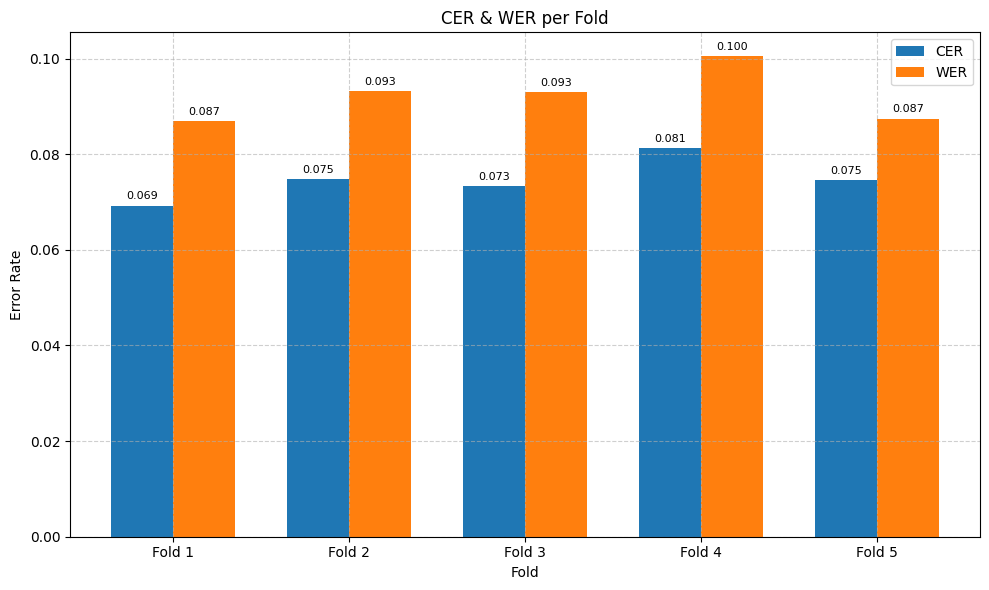

In [12]:
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import matplotlib.pyplot as plt
import editdistance
import os
from collections import Counter

# === Load mapping label numerik ke fonem ===
with open('ngalagena_swara_labels.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
int_to_label = {int(v): k for k, v in label_map.items()}

def decode_prediction(pred, input_length):
    decoded, _ = ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)
    return decoded[0].numpy()

def cer(s1, s2):
    return editdistance.eval(s1, s2) / len(s2) if len(s2) > 0 else 1.0

def wer(ref, hyp):
    ref_words = ref.strip().split()
    hyp_words = hyp.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 1.0

def evaluate_model(model_path, json_path):
    model = load_model(model_path, compile=False)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    cer_list = []
    wer_list = []
    true_texts = []
    pred_texts = []

    for item in tqdm(data, desc=f"Evaluating {os.path.basename(model_path)}", leave=False):
        img_path = item["url_file"]
        label = item["label"]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        y_pred = model.predict(img, verbose=0)
        decoded = decode_prediction(y_pred, input_length=np.array([y_pred.shape[1]]))

        pred_int = decoded[0]
        true_str = " ".join([int_to_label[i] for i in label])
        pred_str = " ".join([int_to_label.get(i, '') for i in pred_int if i in int_to_label])

        true_texts.append(true_str)
        pred_texts.append(pred_str)

        cer_list.append(cer(pred_str, true_str))
        wer_list.append(wer(true_str, pred_str))

    return np.mean(cer_list), np.mean(wer_list), true_texts, pred_texts

def main():
    json_path = "ctc_dataset/combined_file_list_validation.json"
    model_dir = "ctc_dataset/saved_models/finetune_v2_revision"
    output_dir = "evaluation_output/finetune_v2_revision"
    os.makedirs(output_dir, exist_ok=True)

    cer_scores = []
    wer_scores = []
    folds = []
    total_error_counter = Counter()

    for i in range(5):
        model_path = os.path.join(model_dir, f"infer_model_fold_{i}.h5")
        cer_score, wer_score, true_texts, pred_texts = evaluate_model(model_path, json_path)

        cer_scores.append(cer_score)
        wer_scores.append(wer_score)
        folds.append(f"Fold {i+1}")

        # === Hitung kesalahan kata ===
        error_counter = Counter()
        for true_text, pred_text in zip(true_texts, pred_texts):
            if true_text != pred_text:
                error_counter[true_text] += 1
                total_error_counter[true_text] += 1

        # Simpan per fold
        with open(os.path.join(output_dir, f"errors_fold_{i}.json"), 'w', encoding='utf-8') as f:
            json.dump(error_counter.most_common(), f, indent=4, ensure_ascii=False)

        print(f"✅ Fold {i} - CER: {cer_score:.4f}, WER: {wer_score:.4f}")
        print(f"📄 Kesalahan disimpan ke errors_fold_{i}.json")

    # === Simpan total kesalahan seluruh fold ===
    total_error_path = os.path.join(output_dir, "top_errors_all_folds.json")
    with open(total_error_path, 'w', encoding='utf-8') as f:
        json.dump(total_error_counter.most_common(), f, indent=4, ensure_ascii=False)

    print(f"🧾 Total kesalahan disimpan ke: {total_error_path}")

    # === Visualisasi Top 10 Kesalahan ===
    top_n = 10
    top_errors = total_error_counter.most_common(top_n)
    if top_errors:
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(words[::-1], counts[::-1], color='salmon')
        plt.xlabel("Jumlah Kesalahan")
        plt.title(f"Top {top_n} Kata yang Paling Sering Salah Prediksi")

        # Tambahkan angka di ujung bar
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.5,              # posisi X (geser sedikit ke kanan)
                    bar.get_y() + bar.get_height() / 2,  # posisi Y tengah bar
                    f'{int(width)}',          # nilai angka
                    va='center', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "top_misclassified_words.png"))
        plt.close()
        print(f"📊 Visualisasi kesalahan disimpan ke: {output_dir}/top_misclassified_words.png")
    else:
        print("✅ Tidak ada kesalahan terdeteksi!")


    # === Visualisasi CER/WER ===
    x = np.arange(len(folds))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cer_scores, width, label='CER')
    rects2 = ax.bar(x + width/2, wer_scores, width, label='WER')

    ax.set_ylabel('Error Rate')
    ax.set_xlabel('Fold')
    ax.set_title('CER & WER per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "evaluation_plot.png"))
    print(f"📊 Grafik CER & WER disimpan ke: {output_dir}/evaluation_plot.png")

if __name__ == "__main__":
    main()


✅ Fold 0 - CER: 0.6492, WER: 0.9075
📄 Kesalahan disimpan ke errors_fold_0.json


✅ Fold 1 - CER: 0.6148, WER: 0.8850
📄 Kesalahan disimpan ke errors_fold_1.json


✅ Fold 2 - CER: 0.6516, WER: 0.8900
📄 Kesalahan disimpan ke errors_fold_2.json


✅ Fold 3 - CER: 0.6203, WER: 0.8367
📄 Kesalahan disimpan ke errors_fold_3.json


✅ Fold 4 - CER: 0.6007, WER: 0.8817
📄 Kesalahan disimpan ke errors_fold_4.json
🧾 Total kesalahan disimpan ke: evaluation_output/finetune_v2_revision/top_errors_all_folds.json
📊 Visualisasi kesalahan disimpan ke: evaluation_output/finetune_v2_revision/top_misclassified_words.png
📊 Grafik CER & WER disimpan ke: evaluation_output/finetune_v2_revision/evaluation_plot.png


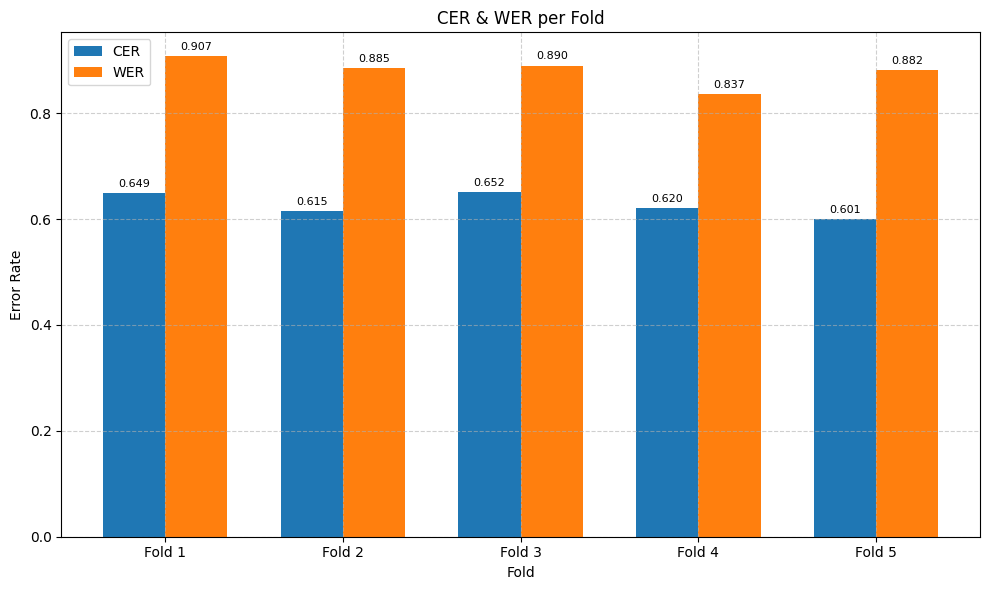

In [13]:
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import matplotlib.pyplot as plt
import editdistance
import os
from collections import Counter

# === Load mapping label numerik ke fonem ===
with open('ngalagena_swara_labels.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
int_to_label = {int(v): k for k, v in label_map.items()}

def decode_prediction(pred, input_length):
    decoded, _ = ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)
    return decoded[0].numpy()

def cer(s1, s2):
    return editdistance.eval(s1, s2) / len(s2) if len(s2) > 0 else 1.0

def wer(ref, hyp):
    ref_words = ref.strip().split()
    hyp_words = hyp.strip().split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 1.0

def evaluate_model(model_path, json_path):
    model = load_model(model_path, compile=False)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    cer_list = []
    wer_list = []
    true_texts = []
    pred_texts = []

    for item in tqdm(data, desc=f"Evaluating {os.path.basename(model_path)}", leave=False):
        img_path = item["url_file"]
        label = item["label"]

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        y_pred = model.predict(img, verbose=0)
        decoded = decode_prediction(y_pred, input_length=np.array([y_pred.shape[1]]))

        pred_int = decoded[0]
        true_str = " ".join([int_to_label[i] for i in label])
        pred_str = " ".join([int_to_label.get(i, '') for i in pred_int if i in int_to_label])

        true_texts.append(true_str)
        pred_texts.append(pred_str)

        cer_list.append(cer(pred_str, true_str))
        wer_list.append(wer(true_str, pred_str))

    return np.mean(cer_list), np.mean(wer_list), true_texts, pred_texts

def main():
    json_path = "ctc_dataset/combined_file_list_new_validation.json"
    model_dir = "ctc_dataset/saved_models/finetune_v2_revision"
    output_dir = "evaluation_output/finetune_v2_revision"
    os.makedirs(output_dir, exist_ok=True)

    cer_scores = []
    wer_scores = []
    folds = []
    total_error_counter = Counter()

    for i in range(5):
        model_path = os.path.join(model_dir, f"infer_model_fold_{i}.h5")
        cer_score, wer_score, true_texts, pred_texts = evaluate_model(model_path, json_path)

        cer_scores.append(cer_score)
        wer_scores.append(wer_score)
        folds.append(f"Fold {i+1}")

        # === Hitung kesalahan kata ===
        error_counter = Counter()
        for true_text, pred_text in zip(true_texts, pred_texts):
            if true_text != pred_text:
                error_counter[true_text] += 1
                total_error_counter[true_text] += 1

        # Simpan per fold
        with open(os.path.join(output_dir, f"errors_fold_{i}.json"), 'w', encoding='utf-8') as f:
            json.dump(error_counter.most_common(), f, indent=4, ensure_ascii=False)

        print(f"✅ Fold {i} - CER: {cer_score:.4f}, WER: {wer_score:.4f}")
        print(f"📄 Kesalahan disimpan ke errors_fold_{i}.json")

    # === Simpan total kesalahan seluruh fold ===
    total_error_path = os.path.join(output_dir, "top_errors_all_folds.json")
    with open(total_error_path, 'w', encoding='utf-8') as f:
        json.dump(total_error_counter.most_common(), f, indent=4, ensure_ascii=False)

    print(f"🧾 Total kesalahan disimpan ke: {total_error_path}")

    # === Visualisasi Top 10 Kesalahan ===
    top_n = 10
    top_errors = total_error_counter.most_common(top_n)
    if top_errors:
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(words[::-1], counts[::-1], color='salmon')
        plt.xlabel("Jumlah Kesalahan")
        plt.title(f"Top {top_n} Kata yang Paling Sering Salah Prediksi")

        # Tambahkan angka di ujung bar
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.5,              # posisi X (geser sedikit ke kanan)
                    bar.get_y() + bar.get_height() / 2,  # posisi Y tengah bar
                    f'{int(width)}',          # nilai angka
                    va='center', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "top_misclassified_words.png"))
        plt.close()
        print(f"📊 Visualisasi kesalahan disimpan ke: {output_dir}/top_misclassified_words.png")
    else:
        print("✅ Tidak ada kesalahan terdeteksi!")


    # === Visualisasi CER/WER ===
    x = np.arange(len(folds))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, cer_scores, width, label='CER')
    rects2 = ax.bar(x + width/2, wer_scores, width, label='WER')

    ax.set_ylabel('Error Rate')
    ax.set_xlabel('Fold')
    ax.set_title('CER & WER per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "evaluation_plot.png"))
    print(f"📊 Grafik CER & WER disimpan ke: {output_dir}/evaluation_plot.png")

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


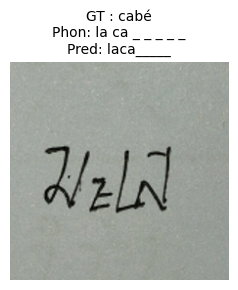

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


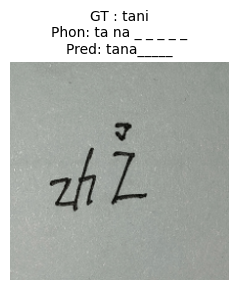

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


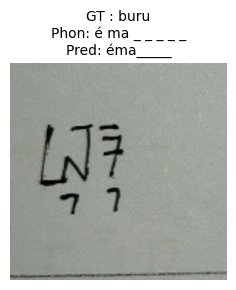

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


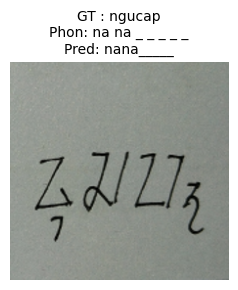

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


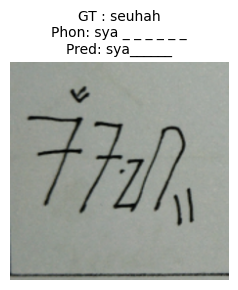

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


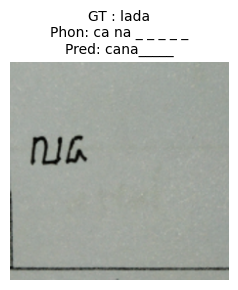

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


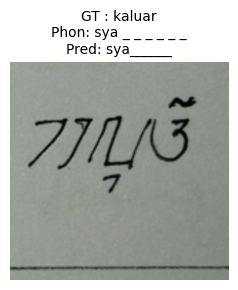

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


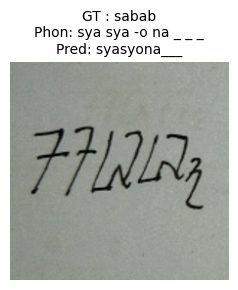

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


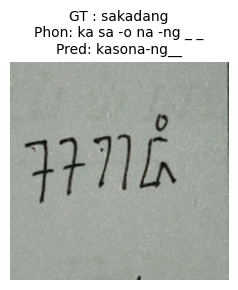

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


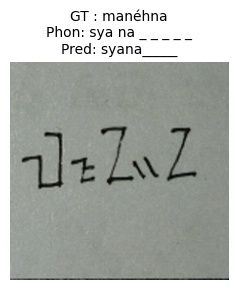

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


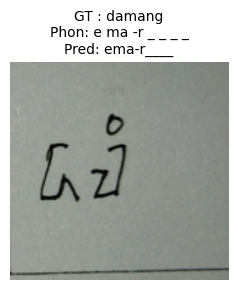

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


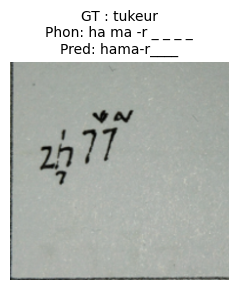

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


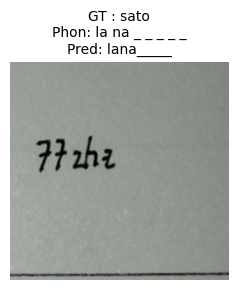

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


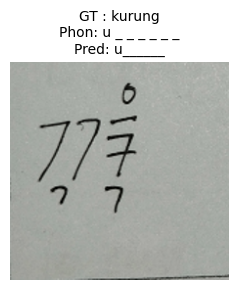

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


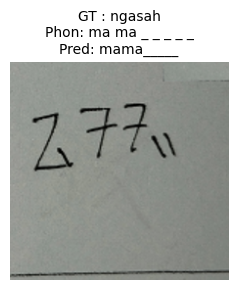

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


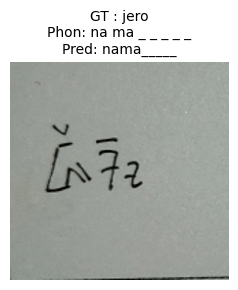

1/1 ━━━━━━━━━━━━━━━━━━━━ -13s -12739394us/step


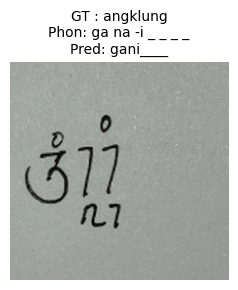

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


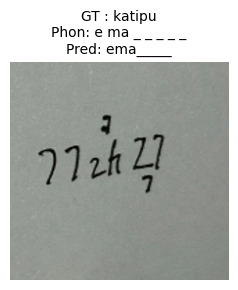

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


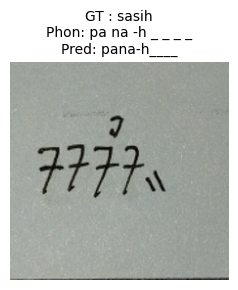

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


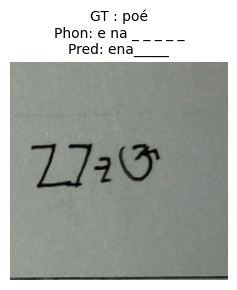

In [14]:
phonetic_map = {
    "a": 1, "i": 2, "u": 3, "e": 4, "o": 5, "é": 6, "eu": 7,
    "ka": 8, "ga": 9, "nga": 10, "ca": 11, "ja": 12, "nya": 13,
    "ta": 14, "da": 15, "na": 16, "pa": 17, "ba": 18, "ma": 19,
    "ya": 20, "ra": 21, "la": 22, "wa": 23, "sa": 24, "ha": 25,
    "fa": 26, "qa": 27, "va": 28, "xa": 29, "za": 30, "sya": 31, "kha": 32,
    "-i": 33, "-u": 34, "-é": 35, "-e": 36, "-eu": 37, "-o": 38,
    "-r": 39, "-h": 40, "-ng": 41, "-": 42, "-r-": 43, "-y-": 44, "-l-": 45
}
charset = ["<pad>"] + [k for k, _ in sorted(phonetic_map.items(), key=lambda x: x[1])]

import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0

# ------------------------
# Fungsi Preprocessing Gambar
# ------------------------
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.asarray(img).astype(np.float32) / 255.0
    return img_array, np.expand_dims(img_array, axis=0)

# ------------------------
# Fungsi Konversi Fonem → Kata
# ------------------------
def phonemes_to_word(phonemes):
    word = []
    i = 0
    while i < len(phonemes):
        p = phonemes[i]
        
        if p in ["ka", "ga", "nga", "ca", "ja", "nya", "ta", "da", "na",
                 "pa", "ba", "ma", "ya", "ra", "la", "wa", "sa", "ha",
                 "fa", "qa", "va", "xa", "za", "sya", "kha"]:
            
            base = p
            next_phoneme = phonemes[i+1] if i + 1 < len(phonemes) else None

            if next_phoneme in ["-r-", "-y-", "-l-"]:
                base = base[0] + next_phoneme.strip("-") + base[1:]
                i += 1
                next_phoneme = phonemes[i+1] if i + 1 < len(phonemes) else None

            if next_phoneme in ["-i", "-u", "-é", "-e", "-eu", "-o"]:
                word.append(base[:-1] + next_phoneme[1:])  # ganti vokal
                i += 1
            elif next_phoneme == "-":
                word.append(base[:-1])  # hilangkan vokal
                i += 1
            else:
                word.append(base)
        else:
            word.append(p)  # swara / simbol langsung
        i += 1
    return "".join(word)

# ------------------------
# Fungsi Decode CTC
# ------------------------
def decode_predictions_single_image(preds, charset):
    decoded = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1])[0][0]
    decoded = tf.keras.backend.get_value(decoded)
    results = []
    for row in decoded:
        tokens = []
        for c in row:
            if c != -1 and c < len(charset):
                tokens.append(charset[c])
            else:
                tokens.append("_")
        results.append(" ".join(tokens))
    return results

def build_efficientnet_cnn_rnn_ctc(vocab_size=51, input_shape=(224, 224, 3)):
    input_img = layers.Input(shape=input_shape, name='image_ctc')
    base_model = EfficientNetB0(include_top=False, input_tensor=input_img, weights='imagenet')

    FINE_TUNE = True
    if not FINE_TUNE:
        base_model.trainable = False  # Bekukan semua layer
    else:
        # Opsi 1: Fine-tune sebagian dari layer (misal mulai dari layer ke-200)
        fine_tune_at = 163
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dropout(0,2)(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
    # x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)
    # shape = tf.shape(x)
    # x = tf.keras.layers.Reshape((-1, x.shape[-1]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    logits = layers.Dense(vocab_size, activation='softmax', name='logits')(x)

    labels = layers.Input(name='labels', shape=(None,), dtype='int32')
    input_length = layers.Input(name='input_length', shape=(1,), dtype='int32')
    label_length = layers.Input(name='label_length', shape=(1,), dtype='int32')
    loss_out = layers.Lambda(ctc_lambda_func, name='ctc')([logits, labels, input_length, label_length])

    model = Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)
    return model

# ------------------------
# Fungsi Prediksi + Tampilkan
# ------------------------
def predict_and_display(model_path, image_path, charset, vocab_size):
    # Build dan load model
    model = build_efficientnet_cnn_rnn_ctc(vocab_size=vocab_size)
    model.load_weights(model_path)

    # Ambil model output logits (tanpa wrapper loss)
    input_img = model.inputs[0]
    logits_output = model.get_layer('logits').output
    pred_model = Model(inputs=input_img, outputs=logits_output)

    # Preprocess gambar
    img_array, img_input = preprocess_image(image_path)

    # Lakukan prediksi
    preds = pred_model.predict(img_input)
    decoded_text = decode_predictions_single_image(preds, charset)[0]  # hasil fonem string

    # Ambil label ground truth dari folder parent
    true_label_str = os.path.basename(image_path).split(".")[0]

    # Konversi fonem ke list → kata
    phonemes = decoded_text.split()
    word = phonemes_to_word(phonemes)

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(3,3))
    plt.imshow(img_array)
    plt.title(f"GT : {true_label_str}\nPhon: {decoded_text}\nPred: {word}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

model_path = "ctc_dataset/saved_models/finetune_v2_revision/infer_model_fold_0.h5"
image_path = [
    "ctc_dataset/new_validation/cab\u00e9.png",
    "ctc_dataset/new_validation/tani.png",
    "ctc_dataset/new_validation/buru.png",
    "ctc_dataset/new_validation/ngucap.png",
    "ctc_dataset/new_validation/seuhah.png",
    "ctc_dataset/new_validation/lada.png",
    "ctc_dataset/new_validation/kaluar.png",
    "ctc_dataset/new_validation/sabab.png",
    "ctc_dataset/new_validation/sakadang.png",
    "ctc_dataset/new_validation/man\u00e9hna.png",
    "ctc_dataset/new_validation/damang.png",
    "ctc_dataset/new_validation/tukeur.png",
    "ctc_dataset/new_validation/sato.png",
    "ctc_dataset/new_validation/kurung.png",
    "ctc_dataset/new_validation/ngasah.png",
    "ctc_dataset/new_validation/jero.png",
    "ctc_dataset/new_validation/angklung.png",
    "ctc_dataset/new_validation/katipu.png",
    "ctc_dataset/new_validation/sasih.png",
    "ctc_dataset/new_validation/po\u00e9.png",
]

for image_url in image_path:
    predict_and_display(model_path, image_url, charset, vocab_size=len(charset))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


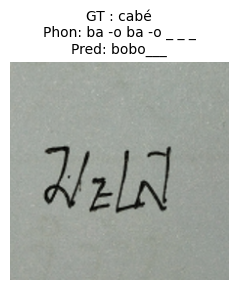

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


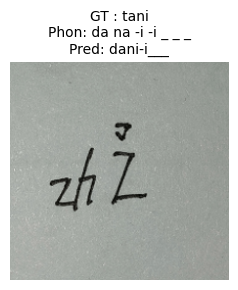

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


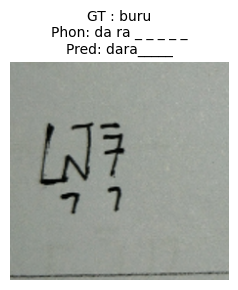

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


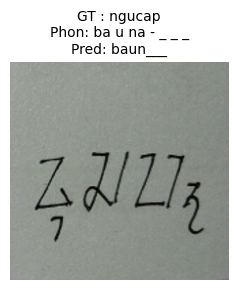

1/1 ━━━━━━━━━━━━━━━━━━━━ -12s -12294131us/step


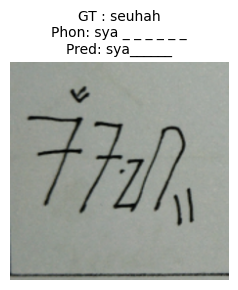

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


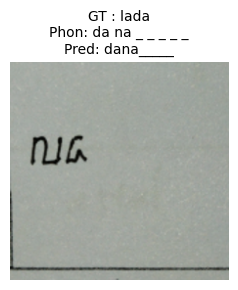

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


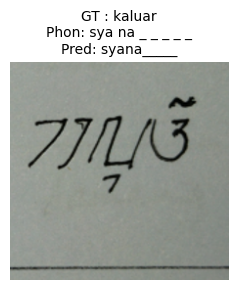

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


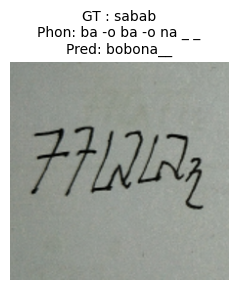

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


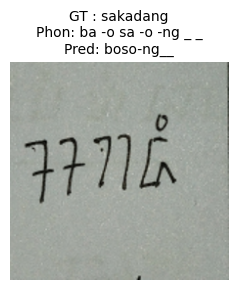

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


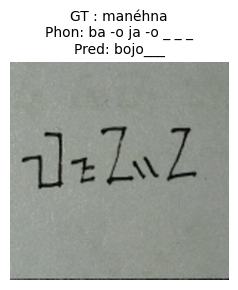

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


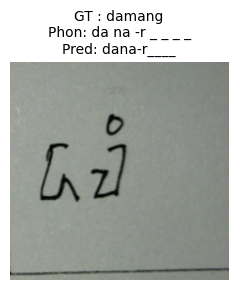

1/1 ━━━━━━━━━━━━━━━━━━━━ -13s -12889996us/step


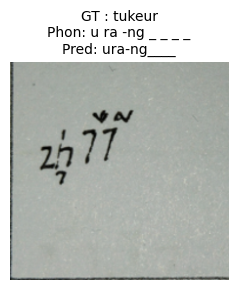

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


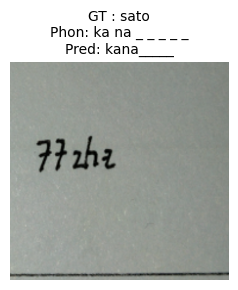

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


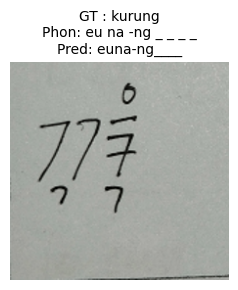

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


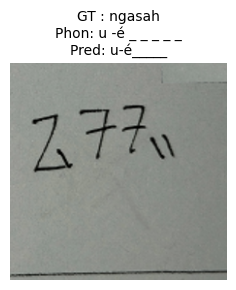

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


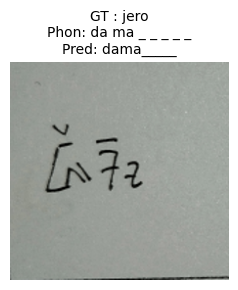

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


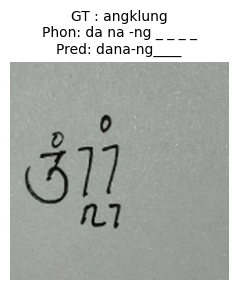

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


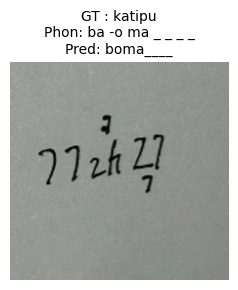

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


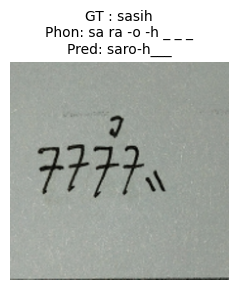

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


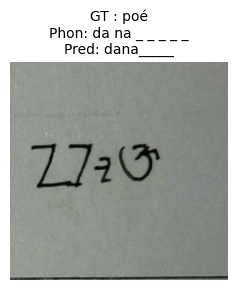

In [5]:
model_path = "ctc_dataset/saved_models/finetune_v2_revision/infer_model_fold_0.h5"
for image_url in image_path:
    predict_and_display(model_path, image_url, charset, vocab_size=len(charset))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


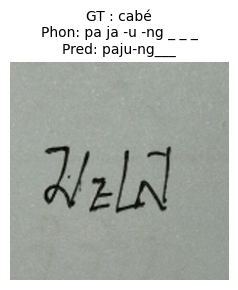

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


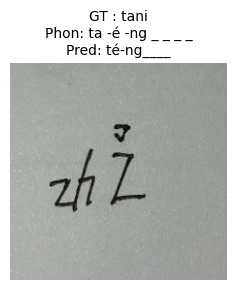

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


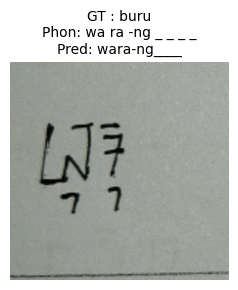

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


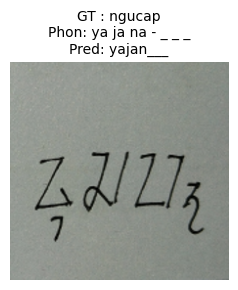

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


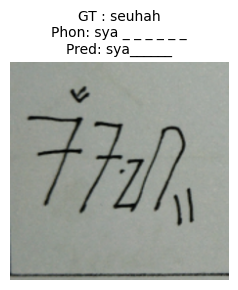

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


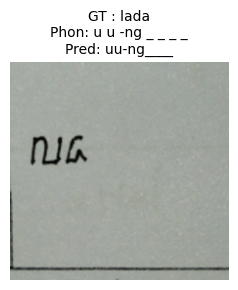

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


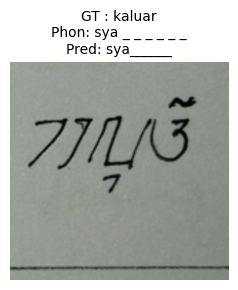

1/1 ━━━━━━━━━━━━━━━━━━━━ -13s -12926529us/step


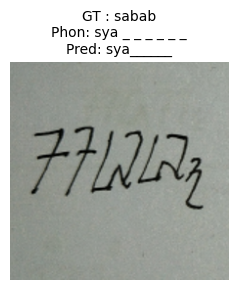

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


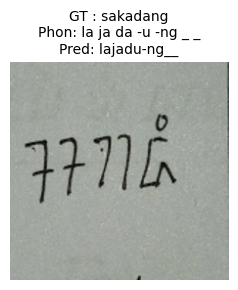

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


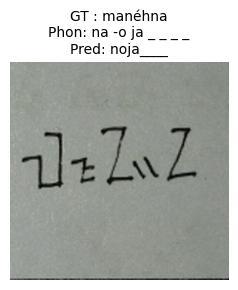

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


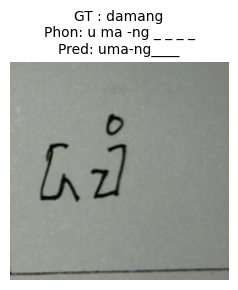

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


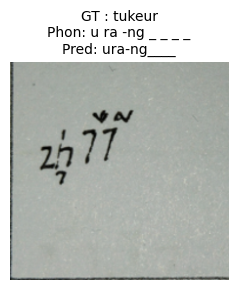

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


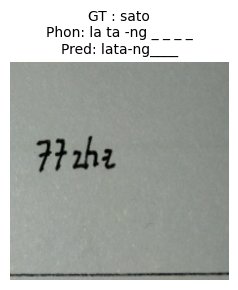

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


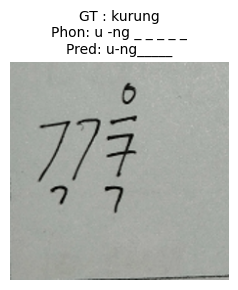

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


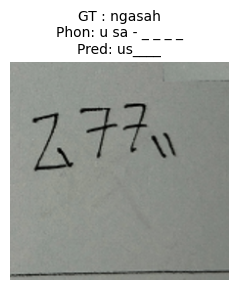

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


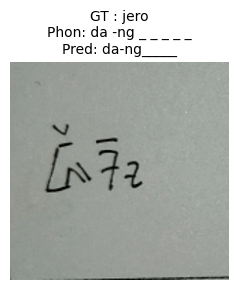

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


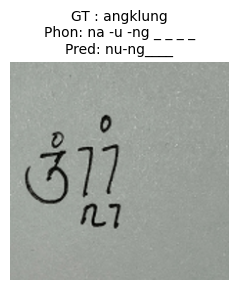

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


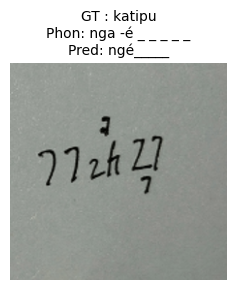

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


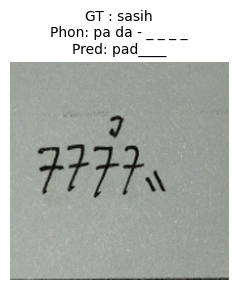

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


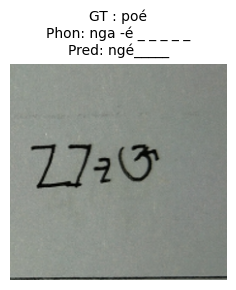

In [6]:
model_path = "ctc_dataset/saved_models/finetune_v2_revision/infer_model_fold_1.h5"
for image_url in image_path:
    predict_and_display(model_path, image_url, charset, vocab_size=len(charset))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


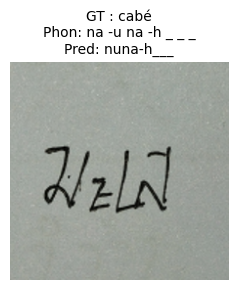

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


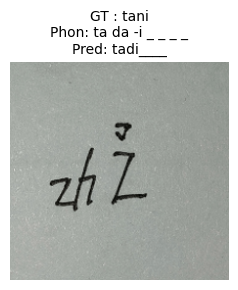

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


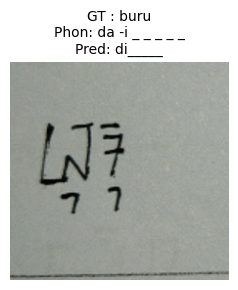

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


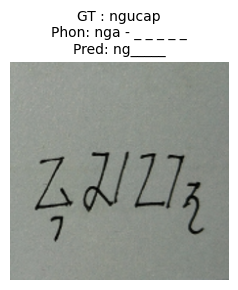

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


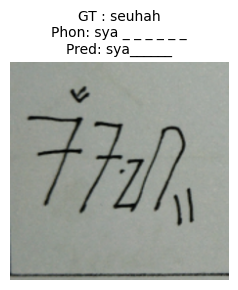

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


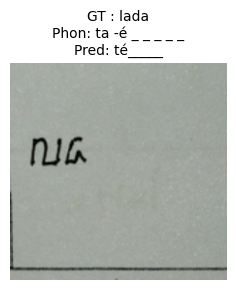

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


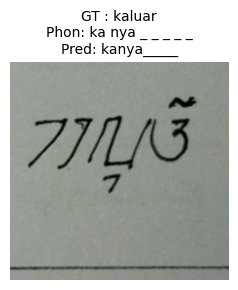

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


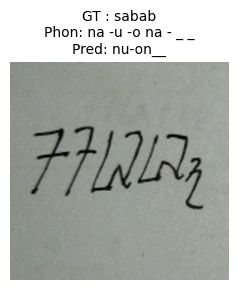

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


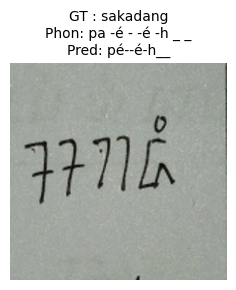

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 


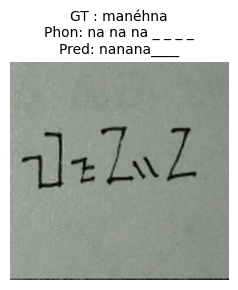

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


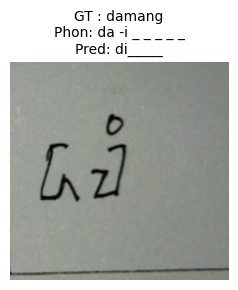

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


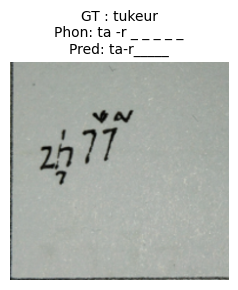

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


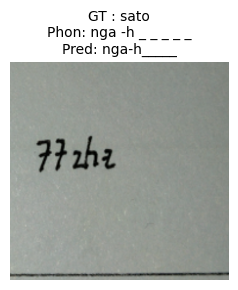

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


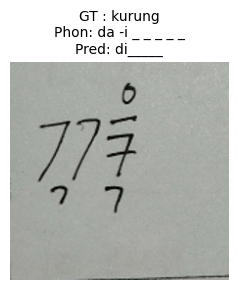

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


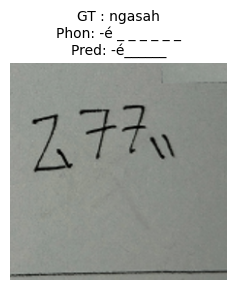

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


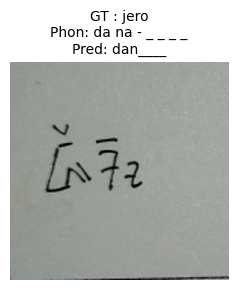

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


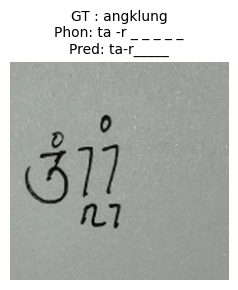

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


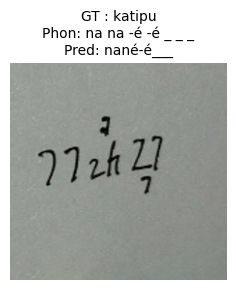

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


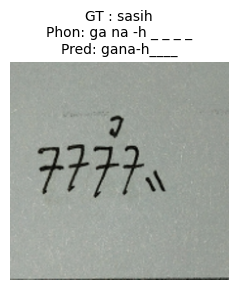

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


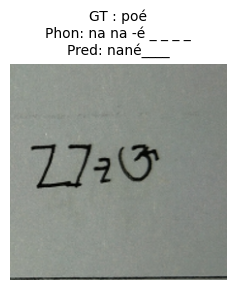

In [7]:
model_path = "ctc_dataset/saved_models/finetune_v2_revision/infer_model_fold_3.h5"
for image_url in image_path:
    predict_and_display(model_path, image_url, charset, vocab_size=len(charset))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


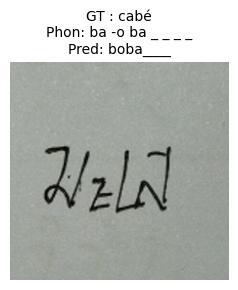

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


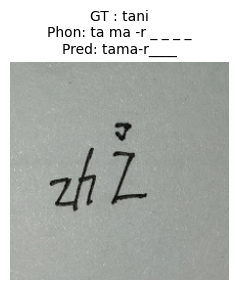

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


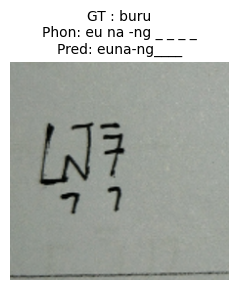

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


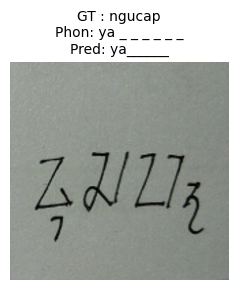

1/1 ━━━━━━━━━━━━━━━━━━━━ -13s -12955587us/step


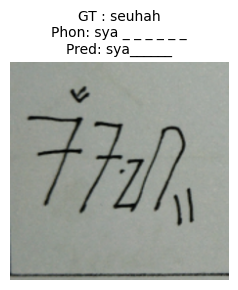

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


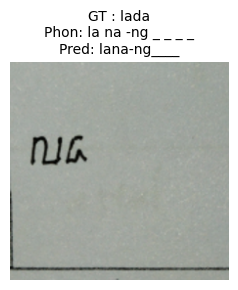

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


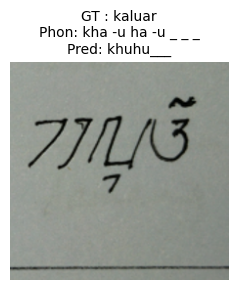

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


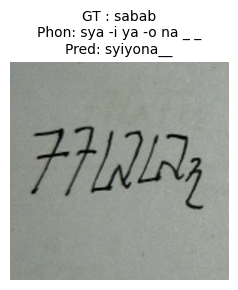

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


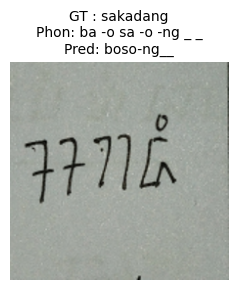

1/1 ━━━━━━━━━━━━━━━━━━━━ -13s -12950255us/step


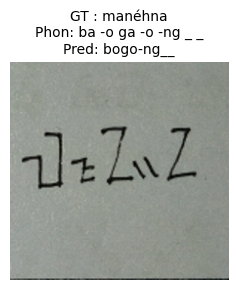

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


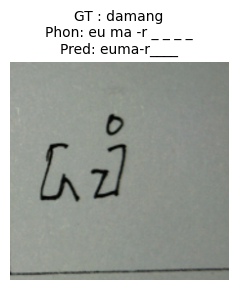

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


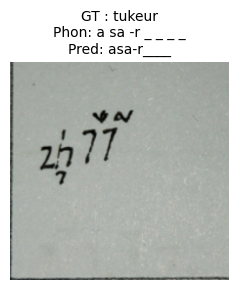

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


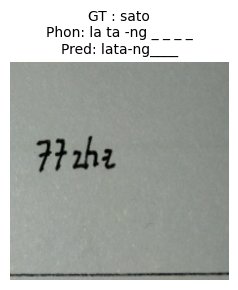

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


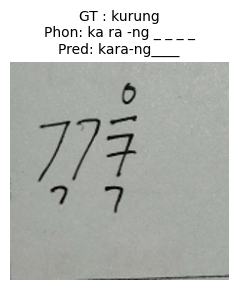

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


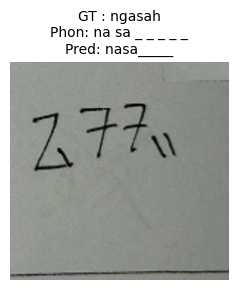

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


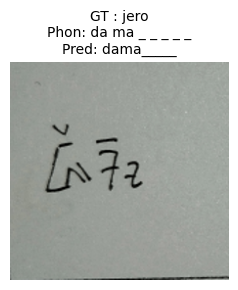

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


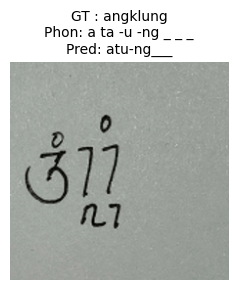

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


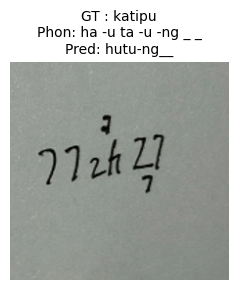

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


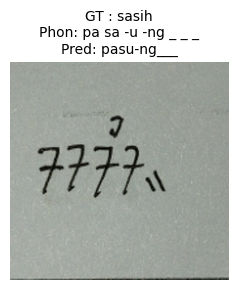

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


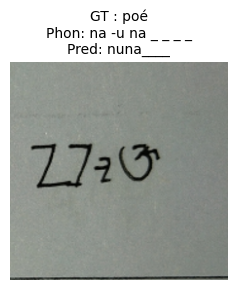

In [8]:
model_path = "ctc_dataset/saved_models/finetune_v2_revision/infer_model_fold_4.h5"
for image_url in image_path:
    predict_and_display(model_path, image_url, charset, vocab_size=len(charset))
